# <span style="color:#c71ab1ff">An example of regression using Quantum Machine Learning</span>

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
jos_palette = ['#4c32ff', '#b332ff', '#61FBF8', '#1E164F', '#c71ab1ff']
sns.set_palette(jos_palette)

import warnings
warnings.filterwarnings('ignore')

## <span style="color:#b332ff">Introduction</span>

### <span style="color:#b332ff">Quantum Machine Learning</span>

In this notebook, we look at how <span style="color:#b332ff">**parametrized quantum circuits**</span> can be used as neural networks to perform a regression task. Using an energy load forecasting dataset and the quantum simulations tools provided by <span style="color:#b332ff">**pennylane**</span>, we look at how quantum machine learning models can perform compared to their classical counterparts.

Machine learning techniques and especially neural networks have drawn much attention in the past few years and shown interesting results in a variety of domains (e.g. image or speech recognition). Their power lies in their ability to fit a broad range of functions and express interesting relations between variables. Quantum Neural Networks harness the properties of quantum mechanics to span a much larger space which could bring a <span style="color:#b332ff">**potential advantage**</span> compared to the classical models.

However, the development of quantum computers is at an early stage where no relevant advantages over classical computers have been obtained for now. Because of the few number of available qubits and other constraints (such as noise or decoherence), the current quantum machine learning models rely on an <span style="color:#b332ff">**hybrid approach**</span> where the quantum circuit is interfaced with a classical computer. The classical machine takes on tasks that are not currently feasible on a quantum processor. This helps save precious quantum resources.

<img src="images/hybrid.png"   width="470px"  height="282.062px"  style="object-fit:cover"/>



### <span style="color:#b332ff">Regression</span>

The problem considered here can be seen as a <span style="color:#b332ff">**supervised**</span> regression task. Given an input space $X$ of features and an output space $Y$. We seek a function $g: X \rightarrow Y$ that is able to <span style="color:#b332ff">**approximate**</span> the output. Here there the output space $Y$ is continuous. This is called a <span style="color:#b332ff">**regression**</span> problem. 

The model is a quantum circuit with <span style="color:#b332ff">**parameters**</span> $\Theta$. It acts as  function $f_\Theta:x\rightarrow \hat{y}=f_\Theta(x)$. The circuit can be viewed as a unitary $\hat{U}_\theta(x)$ and its output $f_\Theta(x)$ as the expectation value of an Hamiltonian $H$. For an input state $\ket{0^{\otimes n}}$, $f_\Theta(x)=\bra{\psi}H\ket{\psi}$ where $\ket{\psi} = \hat{U}_\theta(x)\ket{0^{\otimes n}}$.

During the learning process, the model is fed with <span style="color:#b332ff">**labeled data**</span> $x_i$ for which the output $y_i$ is known. A chosen loss function $L(y_i, \hat{y_i})$ is minimized through a classical <span style="color:#b332ff">**optimization**</span> process (such as gradient descent) on parameters $\Theta$. The loss function estimates how close the model predictions are from the real data. The performances of the model are then evaluated on unseen data.

## <span style="color:#b332ff">Load forecasting data</span>

### <span style="color:#b332ff">Dataset description </span>

| Name | Contained in Set (Train, Test) | Description | Unit |
| ---- | ------------------------------ | ------------| ---- |
| Time  | Train; Test | Timestamp | YYYY-MM-DD HH:MM:SS |
| P | Train | Amount of power generated by the photovoltaic system. |	Watt [W] |
| Gb(i) | Train; Test | Direct in-plane irradiance. It is the fraction of the solar radiation that directly reaches the ground. It is only available if clouds do not block the sun. | Watt per square meter [W/m^2] |
| Gd(i) | Train; Test | Diffuse in-plane irradiance. It is the fraction of solar radiation that reaches the ground after being reflected or scattered by the atmosphere. Its a also available if clouds block the sun. | Watt per square meter [W/m^2] |
| H_sun | Train; Test | Sun height (elevation) | Angle [°] |
| T2m |	Train; Test | Air temperature at 2m | [°C] |
| WS10m | Train; Test | Wind speed at 10m | [m/s] |
| load | Train | Amount of power required by the plant at this timestep. | Watt [W] |
| residual_load | Train | residual_load = load-P. If this value is positive: The amount of power that has to be taken from the grid. If this value is negative: The amount of energy which is fed into the electricity grid. | Watt [W] |
| dataset_id | Train; Test | Train and Test data with the same dataset_id belong together | id |



The path to `dataset.csv` file must be filled in the `filepath` variable so the data can be accessed by the notebook

### <span style="color:#b332ff">Challenge goal</span>

Here we act as a grid operator, we have access to solar panels that produce a certain amount of energy (feature `P`) and we have to meet a certain demand (feature `load`). This gap between the generator power and the load is called the  <span style="color:#b332ff">**residual load**</span> (feature `residual_load`) and it's the thing that we want to  <span style="color:#b332ff">**forecast**</span>. To do so we will proceed in two steps :

- First we will treat the  <span style="color:#b332ff">**load**</span> as a time series. The electricity consumption indeed follow certain  <span style="color:#b332ff">**patterns**</span> depending on the season (time of the year), whether it's the weekend or not, holidays and so on.
- Then we will try to predict the  <span style="color:#b332ff">**power**</span> that is generated by the solar panels using data from  <span style="color:#b332ff">**weather forecasts**</span> (features `Gb(i)`, `Gd(i)`, `H_sun`, `T2m`and `WS10m`)

We will then have an estimation of the  <span style="color:#b332ff">**residual load**</span> by subtracting the two.

<img src="images/approach.png"   height="400px"  style="object-fit:cover"/>


In [2]:
import pandas as pd

filepath = '../data/energy-forecasting-data-challenge/dataset.csv'
data = pd.read_csv(filepath, usecols=['time','P','Gb(i)','Gd(i)','H_sun','T2m','WS10m','load','residual_load','dataset_id', 'train_test'])#, index_col=0) #, index_col=0

In [3]:
data.head()

,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id,train_test
0,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,119.5,119.5,1,train
1,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,113.5,113.5,1,train
2,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,116.5,116.5,1,train
3,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,123.0,123.0,1,train
4,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,117.5,117.5,1,train


In [4]:
data['date_time'] = pd.to_datetime(data['time'])
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)
data['hour'] = data['date_time'].apply(lambda x: x.hour)
data['minute'] = data['date_time'].apply(lambda x: x.minute)
data["weekday"] = data.apply(lambda row: row["date_time"].weekday(), axis=1)
dic = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1}
data['weekend'] = data.weekday.map(dic)

### <span style="color:#b332ff">Train/validation/test split</span>

When developing a machine learning model, we want to be able to make accurate predictions on new, <span style="color:#b332ff">**unseen data**</span>. Is is thus key to assess the performance of the model on data that it has not seen before during the development process. This is where the idea of <span style="color:#b332ff">**splitting**</span> the data into <span style="color:#b332ff">**three sets**</span> comes in :

- The model will be optimized to perform well on the <span style="color:#b332ff">**train set**</span> by optimizing its parameters to minimize the errors.
- The <span style="color:#b332ff">**validation set**</span> set will be used to chose the best hyperparameters of the model.
- The final performance of the model is evaluated on the <span style="color:#b332ff">**test set**</span>.

By splitting the data into these three sets, we can ensure that the model is not <span style="color:#b332ff">**overfitting**</span> ot the training set, that the hyperparameters are choosen in an <span style="color:#b332ff">**unbiased**</span> way on the validation set and that its performance on the test set is a good estimation of how it will succeed on <span style="color:#b332ff">**new data**</span>.


<img src="images/train_test_split.png"   height="200px" style="object-fit:cover"/>


Usually, this split is done <span style="color:#b332ff">**randomly**</span> but here we have to be extra careful. Indeed, when looking at time series, the observations are collected in <span style="color:#b332ff">**chronological order**</span> and there are often relations between adjacent data points. If we randomly shuffle and do the split, we could end up with highly <span style="color:#b332ff">**biased**</span> data. To avoid this, we split the data in a way that maintains the <span style="color:#b332ff">**time order dependence**</span>. To do so, we divide the dataset into 11 time frames of approximatively 4 months. For each of these time frames, a first portion is used for <span style="color:#b332ff">**training**</span>, a second for <span style="color:#b332ff">**validation**</span> and the last for <span style="color:#b332ff">**testing**</span>. By doing this, we train the model on <span style="color:#b332ff">**past**</span> data and evaluate it on <span style="color:#b332ff">**future**</span> data which is consistent.

In [5]:
data_ = data[data['train_test']=='train']
test_data = data[data['train_test']=='test']

train_data = pd.DataFrame()
val_data = pd.DataFrame()

val_size = 0.2

for dataset_id in data_['dataset_id'].unique():
    df_ = data_[data_['dataset_id'] == dataset_id]
    split = int(len(df_) * (1 - val_size))
    train = df_.iloc[:split, :]
    val = df_.iloc[split:, :]
    train_data = pd.concat([train_data, train])
    val_data = pd.concat([val_data, val])

In [6]:
print('Train data shape :', train_data.shape)
print('Validation data shape :', val_data.shape)
print('Test data shape :', test_data.shape)

Train data shape : (70967, 20)
Validation data shape : (17745, 20)
Test data shape : (7392, 20)


## <span style="color:#b332ff">Forecasting of the load</span>

We will deal with the energy load as a time series. The primary goal of this notebook is to demonstrate a small <span style="color:#b332ff">**quantum machine learning**</span> model for regression. Unfortunately, the amount of data here is too big for the <span style="color:#b332ff">**few available qubits**</span> wether in a simulation or on real hardware. We will use a simple classical machine learning approach for this part of the problem so we can then focus on the part that can be tackled with a quantum model.



### <span style="color:#b332ff">Data preparation</span>

Numerous methods can be used for time series forecasting. Here, we don't want to spend too much time on the classical part so we will just try to fit the load series on the date. Each recordings is taken at 15 minutes intervals. From date `YYYY-MM-DD hh:mm:ss`, we will derive five <span style="color:#b332ff">**time features**</span> :

- `year` $\in \{2018, 2019, 2020\}$

- `month` $\in [| 1, 12 |]$

- `day` $\in [| 1, 31 |]$

- `hour` $\in [| 0, 23 |]$

- `minute` $\in \{ 0, 15, 30, 45 \}$`

Because the energy consumption can vary a lot during the week (and especially on <span style="color:#b332ff">**weekends**</span>), we will add two features :

- `weekday` $\in [| 1, 7 |]$ : monday to sunday

- `weekend` $\in \{0, 1\}$ : wether in the weekend or not

#### <span style="color:#b332ff">Holidays and vacations</span>

During holidays, the <span style="color:#b332ff">**energy consumption**</span> is much lower than usual so taking this into account will help improve the performance of the model by a lot.

- The <span style="color:#b332ff">**holidays**</span> for the land of Hessen in Germany are retrieved from the python `holidays` library and added as a <span style="color:#b332ff">**binary feature**</span> `holiday` in the dataset.

- We will also add the <span style="color:#b332ff">**school vacations**</span> for the same area (feature `vacation`) and also the <span style="color:#b332ff">**lockdown**</span> dates for year 2020 (feature `lockdown`).

In [7]:
from datetime import date, timedelta

def get_dates(start_date, end_date):
    """ Return a list of all dates between start_date and end_date (inclusive)."""
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += timedelta(days=1)
    return date_list

In [8]:
import holidays

hessen_holidays = list(holidays.country_holidays('DE', subdiv='HE', years=[2018, 2019, 2020]).keys())
additional_holidays = ['2018-12-24', '2018-12-31', '2019-12-24', '2019-12-31'] #Despite not being official holidays, December 24th and 31st can almost be considered as such

for day in additional_holidays:
    d = day.split('-')
    hessen_holidays.append(date(int(d[0]), int(d[1]), int(d[2])))

holidays_df = pd.DataFrame({'year': [d.year for d in hessen_holidays],
                            'month': [d.month for d in hessen_holidays],
                            'day': [d.day for d in hessen_holidays],
                            'holiday': [1 for d in hessen_holidays]})

data = pd.merge(data, holidays_df, on=['year', 'month', 'day'], how="left")
data['holiday'] = data['holiday'].fillna(0)

In [9]:
hessen_vacations_dict = {
    'Christmas 2017': (date(2018, 1, 1), date(2018, 1, 13)),
    'Easter 2018': (date(2018, 3, 26), date(2018, 4, 7)),
    'Summer 2018': (date(2018, 6, 25), date(2018, 8, 3)),
    'Autumn 2018': (date(2018, 10, 1), date(2018, 10, 13)),
    'Christmas 2018': (date(2018, 12, 24), date(2019, 1, 12)),
    'Easter 2019': (date(2019, 4, 15), date(2019, 4, 27)),
    'Summer 2019': (date(2019, 7, 1), date(2019, 8, 9)),
    'Autumn 2019': (date(2019, 9, 30), date(2019, 10, 12)),
    'Christmas 2019': (date(2019, 12, 23), date(2020, 1, 11)),
    'Easter 2020': (date(2020, 4, 6), date(2020, 4, 18)),
    'Summer 2020': (date(2020, 7, 6), date(2020, 8, 14)),
    'Autumn 2020': (date(2020, 10, 5), date(2020, 10, 17)),
}

hessen_vacations = []
for start_date, end_date in hessen_vacations_dict.values():
    hessen_vacations += get_dates(start_date, end_date)

vacations_df = pd.DataFrame({'year': [d.year for d in hessen_vacations],
                             'month': [d.month for d in hessen_vacations],
                             'day': [d.day for d in hessen_vacations],
                             'vacation': [1 for d in hessen_vacations]})

data = pd.merge(data, vacations_df, on=['year', 'month', 'day'], how="left")
data['vacation'] = data['vacation'].fillna(0)

In [10]:
bridging_days = [date(2018, 4, 30), date(2018, 5, 11), date(2018, 6, 1), date(2018, 12, 24), date(2018, 12, 31), date(2019, 5, 31), date(2019, 6, 21), date(2019, 10, 4), date(2019, 12, 27), date(2020, 5, 22), date(2020, 6, 12)]

bridging_df = pd.DataFrame({'year': [d.year for d in bridging_days],
                             'month': [d.month for d in bridging_days],
                             'day': [d.day for d in bridging_days],
                             'bridging': [1 for d in bridging_days]})

data = pd.merge(data, bridging_df, on=['year', 'month', 'day'], how="left")
data['bridging'] = data['bridging'].fillna(0)

In [11]:
hessen_lockdowns = get_dates(date(2020, 3, 22), date(2020, 4, 19))

lockdowns_df = pd.DataFrame({'year': [d.year for d in hessen_lockdowns],
                             'month': [d.month for d in hessen_lockdowns],
                             'day': [d.day for d in hessen_lockdowns],
                             'lockdown': [1 for d in hessen_lockdowns]})

data = pd.merge(data, lockdowns_df, on=['year', 'month', 'day'], how="left")
data['lockdown'] = data['lockdown'].fillna(0)

#### <span style="color:#b332ff">One-hot encoding</span>
All of these features are <span style="color:#b332ff">**numerical**</span> but there is no actual <span style="color:#b332ff">**ordering**</span> within a feature (tuesday isn't "bigger" than monday). We have to deal with those as <span style="color:#b332ff">**categorical**</span> data so we'll use <span style="color:#b332ff">**one-hot encoding**</span> on each of these features (except for `weekend`, `holiday`, `vacation` and `lockdown` which are already <span style="color:#b332ff">**binary**</span>).

In [12]:
keep_cols = ['load', 'year', 'quarter', 'month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'holiday', 'vacation', 'lockdown', 'bridging']
df_load = pd.get_dummies(data=data[keep_cols], columns=['year', 'quarter', 'month', 'day', 'weekday', 'hour', 'minute'])

In [13]:
df_train_load = df_load.loc[train_data.index, :]
df_val_load = df_load.loc[val_data.index, :]
df_test_load = df_load.loc[test_data.index, :]

### <span style="color:#b332ff">Model fit on the training set</span>

We will use a xgboost model for regression to compute the load from the time feature detailed above. The load is first rescaled to a mean of 0 and a standard deviation of 1.

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler_load = StandardScaler()
X_train_load, y_train_load = np.tensor(df_train_load.drop('load', axis=1)), np.tensor(df_train_load['load'])
y_train_load = std_scaler_load.fit_transform(y_train_load.reshape(-1, 1))

In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_load, y_train_load)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Train MSE = 161.62996932592503


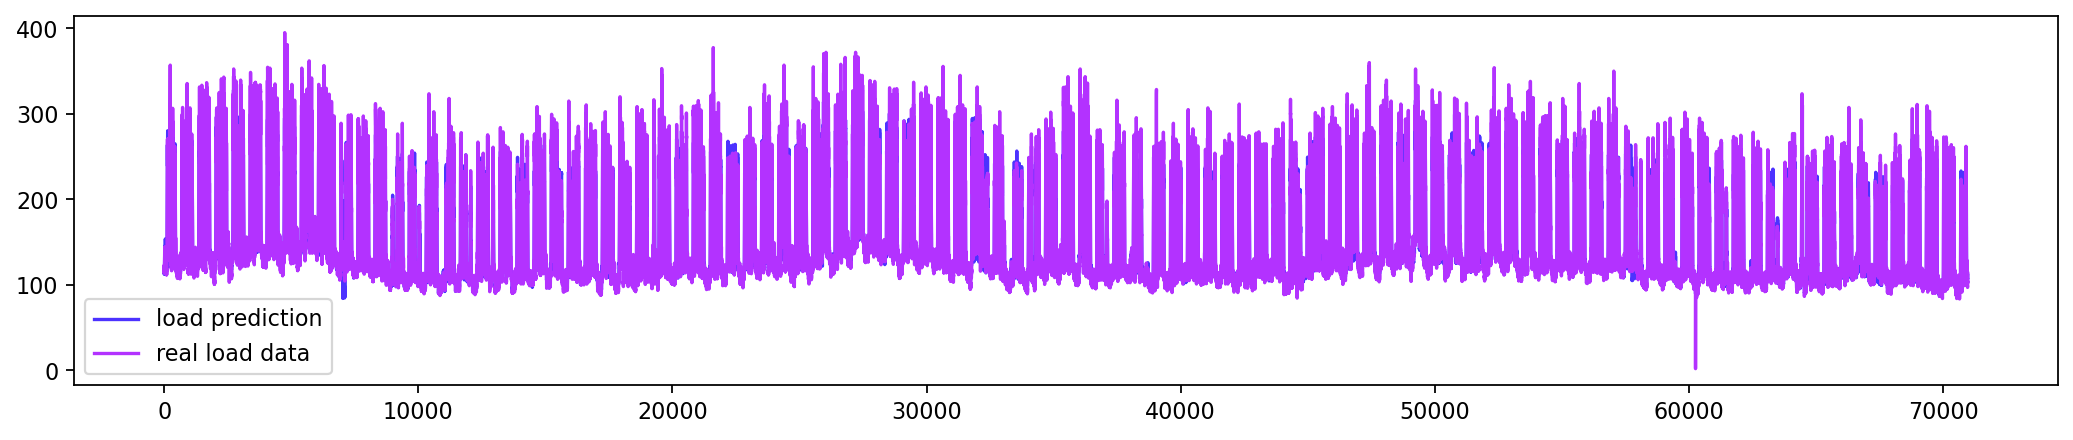

In [16]:
from sklearn.metrics import mean_squared_error

y_hat_train_load = xgb.predict(X_train_load)
y_hat_train_load = std_scaler_load.inverse_transform(y_hat_train_load.reshape(-1, 1))
print('Train MSE =', mean_squared_error(std_scaler_load.inverse_transform(y_train_load), y_hat_train_load))

plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(y_hat_train_load))), y_hat_train_load, label='load prediction')
plt.plot(list(range(len(y_train_load))), std_scaler_load.inverse_transform(y_train_load), label='real load data')
plt.legend()
plt.show()

### <span style="color:#b332ff">Evaluation of the performance on the validation and test sets</span>

The MSE for the validation and test sets is slightly higher than for the training set which could mean that the model overfitted the training data to a certain extent. This issue won't be investigated here as most of the work is directed towards quantum machine learning and the computation of the generated power.


Validation MSE = 436.56211501135334


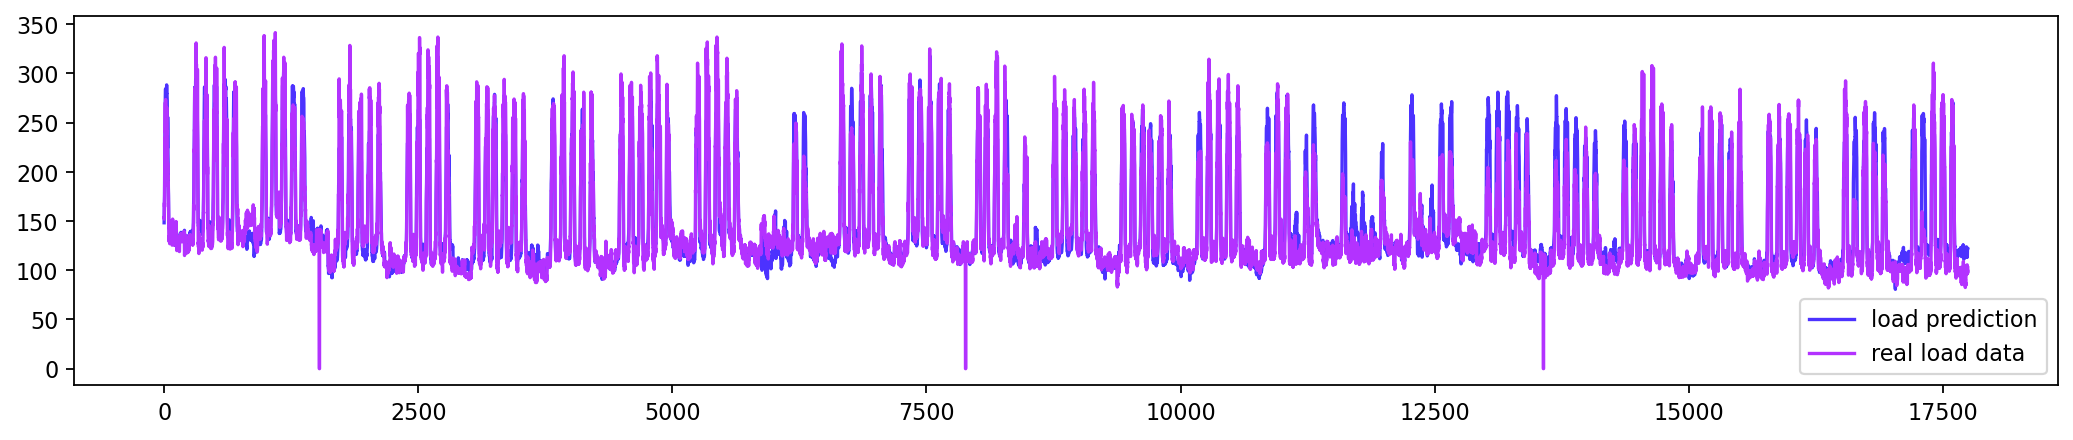

In [17]:
X_val_load, y_val_load = np.tensor(df_val_load.drop('load', axis=1)), np.tensor(df_val_load['load'])
y_hat_val_load = xgb.predict(X_val_load)
y_hat_val_load = std_scaler_load.inverse_transform(y_hat_val_load.reshape(-1, 1))

print('Validation MSE =', mean_squared_error(y_hat_val_load, y_val_load))
plt.figure(figsize=(16,3), dpi=80)
plt.plot(y_hat_val_load, label='load prediction')
plt.plot(y_val_load, label='real load data')
plt.legend()
plt.show()

Test MSE = 320.9250020835612


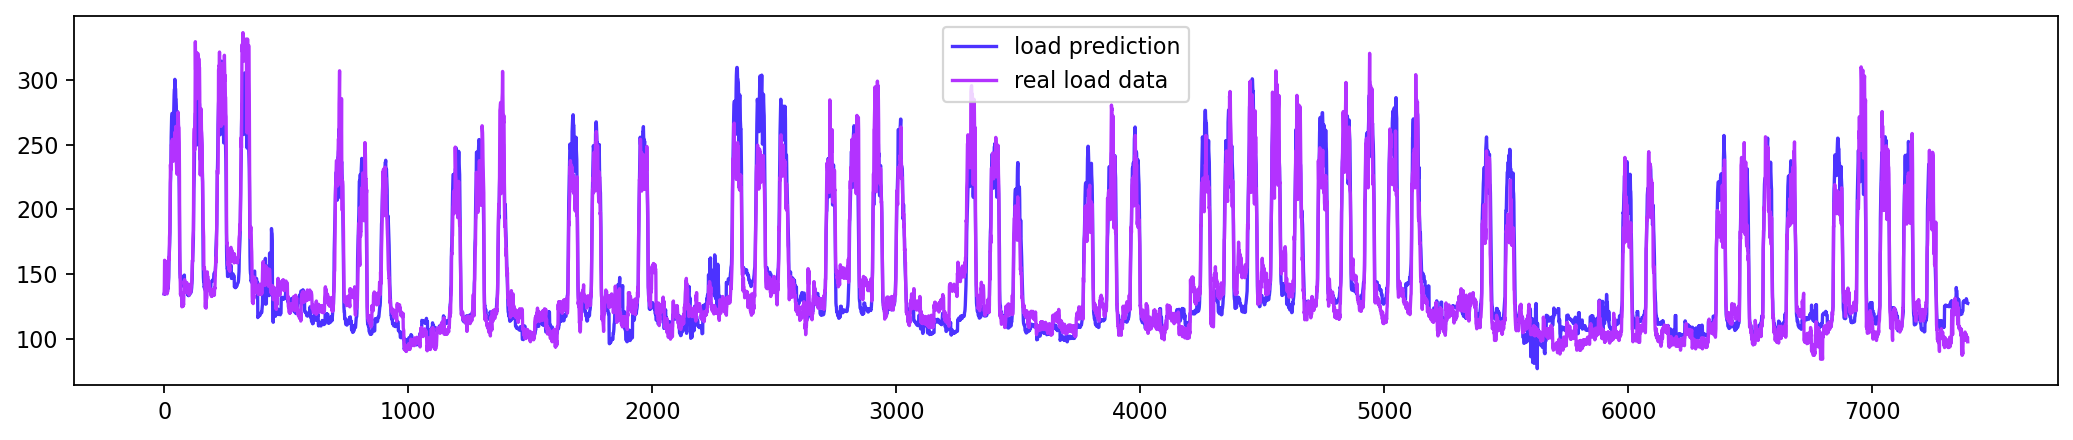

In [18]:
X_test_load, y_test_load = np.tensor(df_test_load.drop('load', axis=1)), np.tensor(df_test_load['load'])

y_hat_test_load = xgb.predict(X_test_load)
y_hat_test_load = std_scaler_load.inverse_transform(y_hat_test_load.reshape(-1, 1))

print('Test MSE =', mean_squared_error(y_hat_test_load, y_test_load))
plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(y_hat_test_load))), y_hat_test_load, label='load prediction')
plt.plot(list(range(len(y_test_load))), y_test_load, label='real load data')
plt.legend()
plt.show()

### <span style="color:#b332ff">Explainability - SHAP</span>

We use SHapley Additive exPlanations (SHAP) to understand which features had the most impact on the model predictions. Features are ranked by importance from top to bottom. The fact that it's the weekend has the biggest impact (negative) on the output. Then we can see that when in the first quarter of the year (january, february, march) , the energy consumption tends to be higher which doesn't seem absurd. Also holidays have a big negative impact and year 2020 has a small negative impact (which could be due to lockdowns during the COVID pandemic).


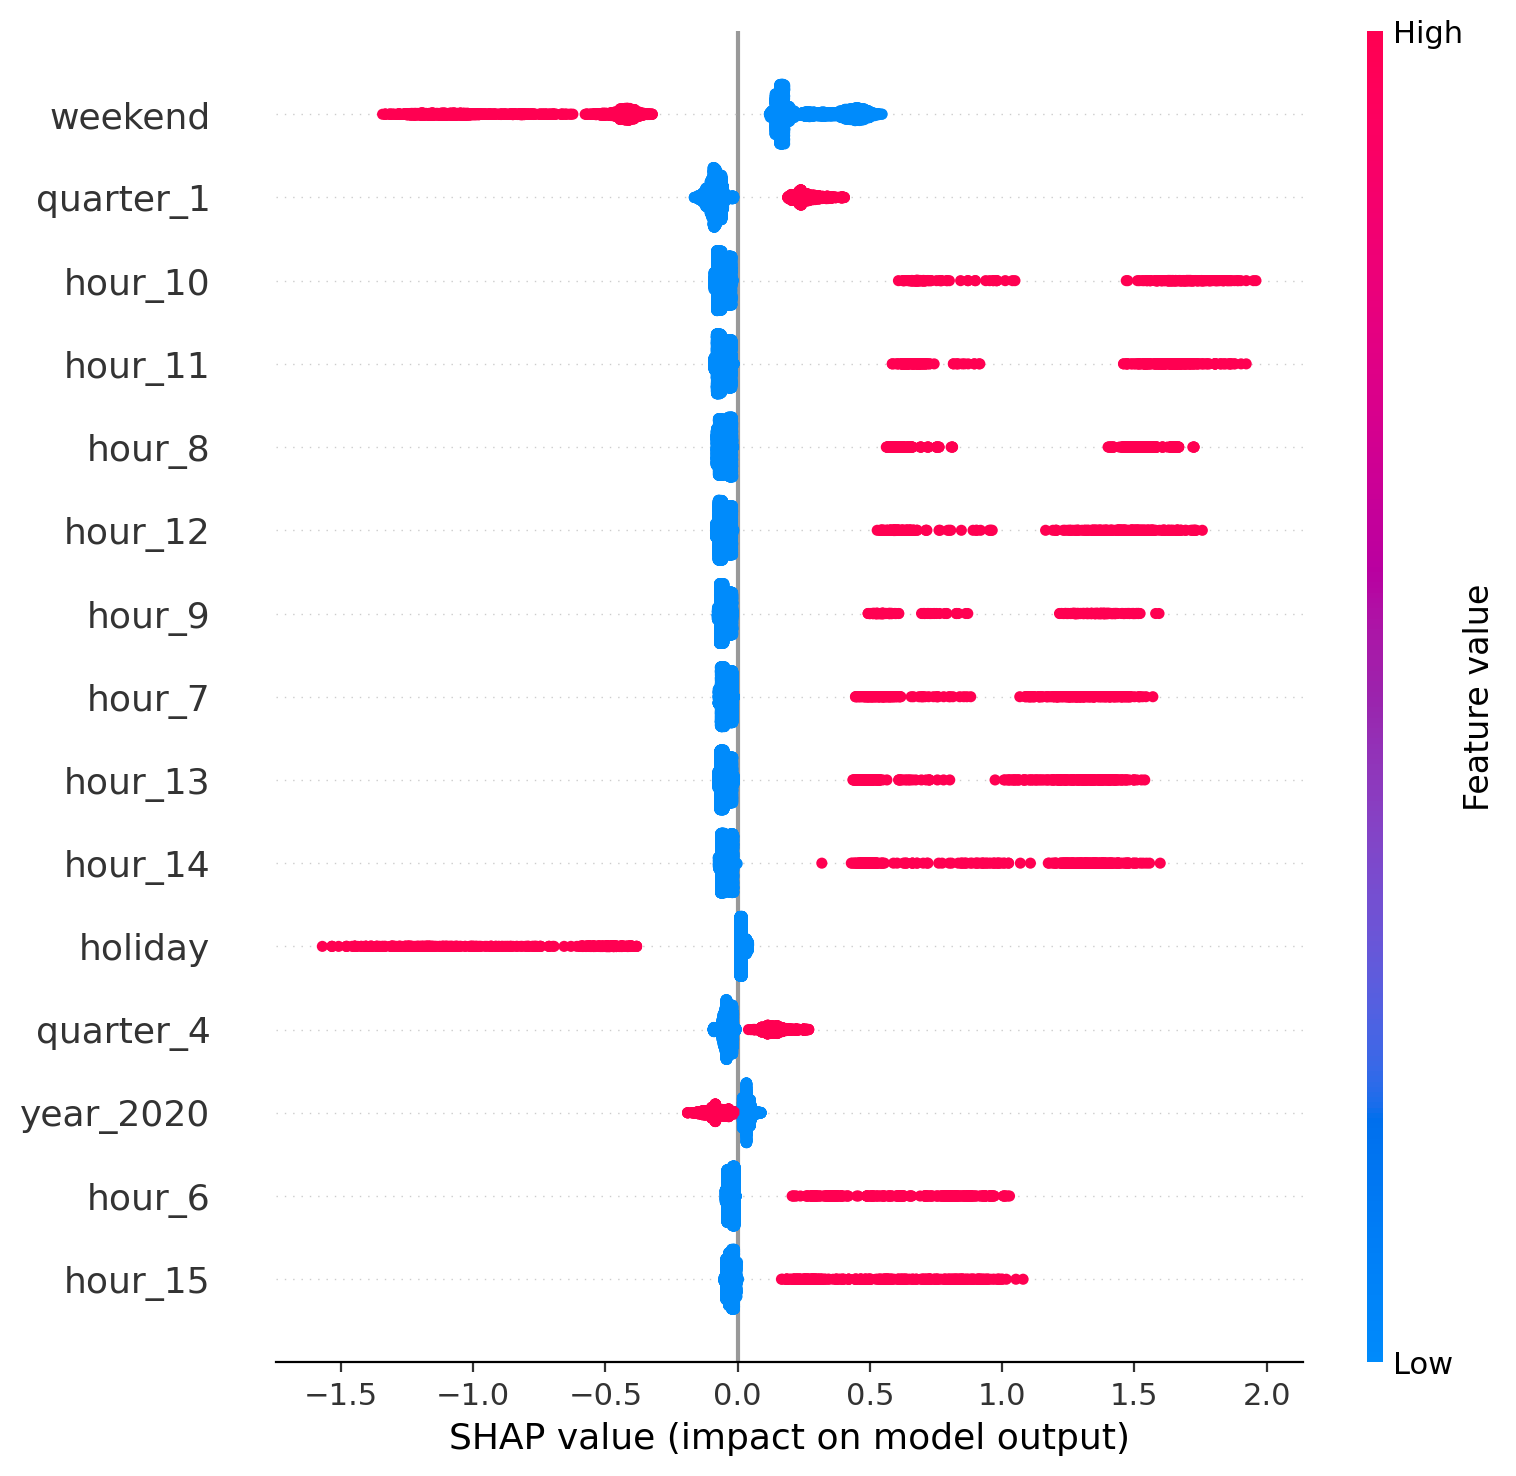

In [19]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_load)
shap.summary_plot(shap_values, X_test_load, feature_names=df_test_load.drop('load', axis=1).columns, max_display=15)


## <span style="color:#b332ff">Estimation of the generated power</span>

The power generated by the photovoltaic system will be estimated at each time steps using 5 meteorogical features :

- `Gb(i)`: Direct in-plane irradiance ($W/m^2$). It is the fraction of the solar radiation that directly reaches the ground. It is only available if clouds do not block the sun.

- `Gd(i)`: Diffuse in-plane irradiance ($W/m^2$). It is the fraction of solar radiation that reaches the ground after being reflected or scattered by the atmosphere. Its a also available if clouds block the sun.

- `H_sun`: Sun height measure by an angle (°)

- `T2m`: Air temperature 2m above the ground (°C)

- `WS10m`: Wind speed 10m above the ground ($m/s$)

We will treat this as a <span style="color:#b332ff">**regression**</span> problem and use a small <span style="color:#b332ff">**quantum neural network**</span> as a model.

In [20]:
keep_cols = ['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m', 'P']

df_train = train_data[keep_cols]
df_val = val_data[keep_cols]
df_test = test_data[keep_cols]

### <span style="color:#b332ff"> Data preparation - Rescaling

All the inputs will be rescaled to a 0 mean and a standard deviation of 1

For the output (the generated power), we will use a min-max scaler so it falls in the -1, 1 range

In [21]:
mm_scaler = MinMaxScaler(feature_range=(0, 0.99))
std_scaler = MinMaxScaler(feature_range=(-0.99, 0.99))

X_train, y_train = np.tensor(df_train.drop('P', axis=1)), np.tensor(df_train['P'])
X_train = std_scaler.fit_transform(X_train)
y_train = mm_scaler.fit_transform(y_train.reshape(-1, 1))
X_val, y_val = np.tensor(df_val.drop('P', axis=1)), np.tensor(df_val['P'])
X_val = std_scaler.transform(X_val)
X_test, y_test = np.tensor(df_test.drop('P', axis=1)), np.tensor(df_test['P'])
X_test = std_scaler.transform(X_test)

### <span style="color:#b332ff">Parametrized Quantum Circuit</span>

<img src="images/pqc.png"   height="202.062px"  style="object-fit:cover"/>

A parametrized quantum circuit (PQC) is essentially defined by three components :

- <span style="color:#b332ff">**Feature Map**</span> : the part of the circuit that encodes the classical data in a superposed quantum state
- <span style="color:#b332ff">**Ansatz**</span> : the variational part of the circuit, which is built of parametrized gates and entangling layers. It transforms the input state so it fits the output data.
- <span style="color:#b332ff">**Measurement**</span> : yields the output through the expectation value of an hamiltonian or the readout of qubits.

Many architectures exist and provide different expressibility or entangling capacities. Here, we will test different architectures and measure the obtained performance for each of them.


#### <span style="color:#b332ff">Feature Map</span>

The <span style="color:#b332ff">**encoding circuit**</span> we choose if a product feature map composed of single qubit rotations. The number of qubits in the circuit is the same as the number of classical values to encode and each value has its own qubit. The feature map can be viewed as a unitary :

\begin{equation*}
U_{\phi(x)} = \bigotimes_{i=1}^n\,R_{\alpha,i}(\phi(x_i))
\end{equation*}

#### <span style="color:#b332ff">Ansatz</span>

The ansatz is the <span style="color:#b332ff">**variational**</span> part of the circuit, it can be defined as a unitary $U_\Theta$ where $\Theta = (\theta_i)_{i\in {1...m}} \in \mathbb{C}^m$ is the set of parameters that is <span style="color:#b332ff">**optimized**</span> during the learning process. Each of these parameters is associated to a particular quantum gate in the ansatz circuit.

The so-called <span style="color:#b332ff">**hardware efficient ansatz**</span> used here was originally designed for VQE (Variational Quantum Eigensolver). It is made of successive layers of single qubits rotations along the three axis of the bloch sphere and a ring of entangling CX gates. We will start with this ansatz, then increase the entangling capability between the single qubits rotations. Then we will use parametrized two qubits rotations.


#### <span style="color:#b332ff">Measurement</span>

While <span style="color:#b332ff">**expectation values**</span> of complex Hamiltonians can be used for the output of the PQC, we only measure the first qubit in the Z basis here.

### <span style="color:#b332ff">PQC architecture : ring-shaped entangling gates</span>

The product feature map will be used for each of the architectures. We will thus need 5 qubits (1 for each feature). The 3 layers of ansatz will give us a total of $3*5*3=45$ trainable parameters. We obtain the following performance :


| Set | MSE | RMSE |
| ---- | ---- | ---- |
| Train | 2667 | 51.64 |
| Validation | 2449 | 49.49 |
| Test | 2262 | 47.56 |


The errors for all three sets are close to one another which means that the model has not overfitted on train data.

In [22]:
import pennylane as qml

n_qubits = 5
n_layers = 3

dev = qml.device('lightning.qubit', wires=n_qubits)

@qml.qnode(dev)
def pqc_ring(weights, x):
    for qb in range(n_qubits):
        qml.RX(2*np.arccos(x[qb]), wires=qb)
        
    for layer in range(n_layers):
        for qb in range(n_qubits):
            qml.RX(weights[layer, qb, 0], wires=qb)
            qml.RY(weights[layer, qb, 1], wires=qb)
            qml.RZ(weights[layer, qb, 2], wires=qb)

        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")

    return qml.expval(qml.PauliZ(0))

(<Figure size 2800x600 with 1 Axes>, <Axes:>)


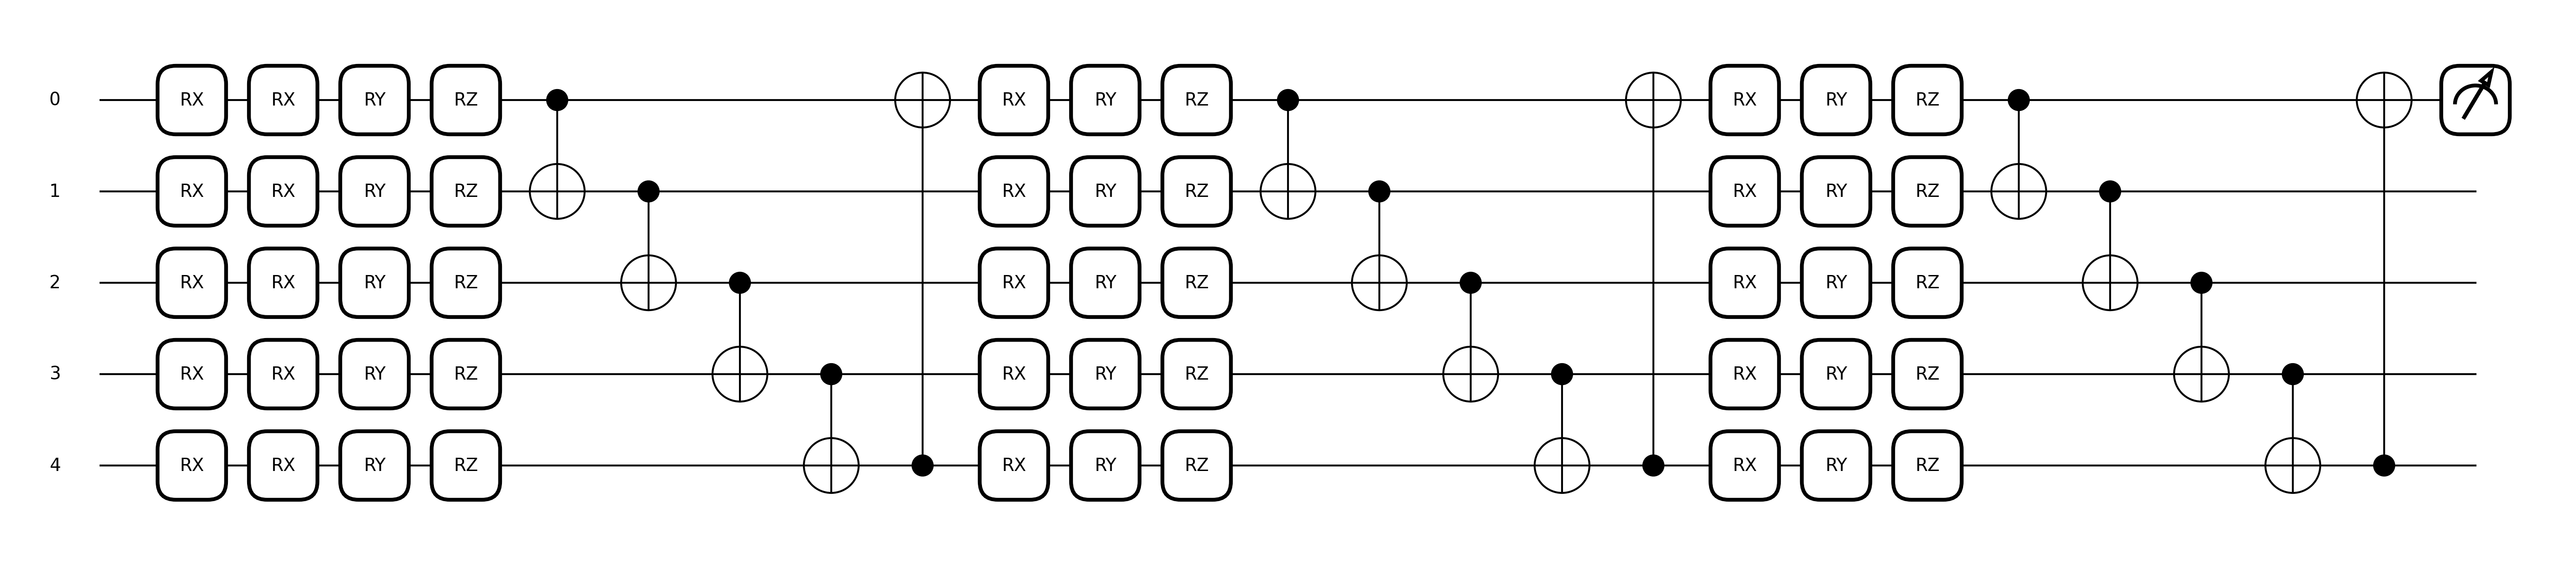

In [23]:
import pygrnd
from pygrnd.qc.qml import QNNRegressor

model = QNNRegressor(pqc_ring, [n_layers, n_qubits, 3])
model.display_circuit()

Model Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 1/10,   train loss = [0.05734723] test_loss = [0.05153152]


Epoch 2:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 2/10,   train loss = [0.03274158] test_loss = [0.02815023]


Epoch 3:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 3/10,   train loss = [0.01911197] test_loss = [0.01651592]


Epoch 4:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 4/10,   train loss = [0.0109987] test_loss = [0.00990866]


Epoch 5:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 5/10,   train loss = [0.00827182] test_loss = [0.00742692]


Epoch 6:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 6/10,   train loss = [0.00713873] test_loss = [0.00640052]


Epoch 7:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 7/10,   train loss = [0.00662386] test_loss = [0.00595411]


Epoch 8:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 8/10,   train loss = [0.00627936] test_loss = [0.00572157]


Epoch 9:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 9/10,   train loss = [0.00605613] test_loss = [0.00555105]


Epoch 10:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch 10/10,   train loss = [0.00592926] test_loss = [0.00544471]


Train MSE = 2667.5053465395285


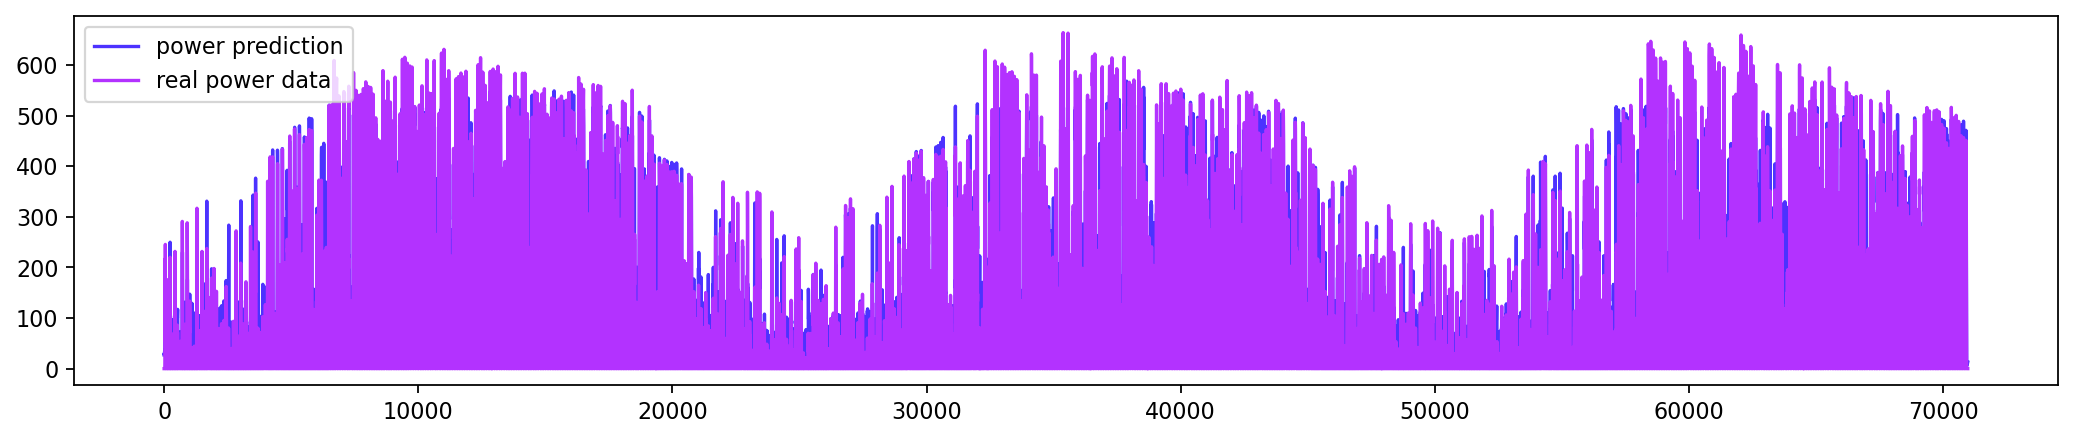

In [24]:
train_losses, test_losses = model.fit(X_train, y_train, X_val, mm_scaler.transform(y_val.reshape(-1, 1)), epochs=10, batch_size=256, optimizer=qml.AdamOptimizer, learning_rate=0.001, verbose=True)

y_hat_train = model.predict(X_train)
y_hat_train = np.array([float(x) for x in y_hat_train])
y_hat_train = mm_scaler.inverse_transform(y_hat_train.reshape(-1, 1))
print('Train MSE =', mean_squared_error(mm_scaler.inverse_transform(y_train), y_hat_train))

plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(y_hat_train))), y_hat_train, label='power prediction')
plt.plot(list(range(len(y_train))), mm_scaler.inverse_transform(y_train), label='real power data')
plt.legend()
plt.show()

Validation MSE = 2449.5113607366584


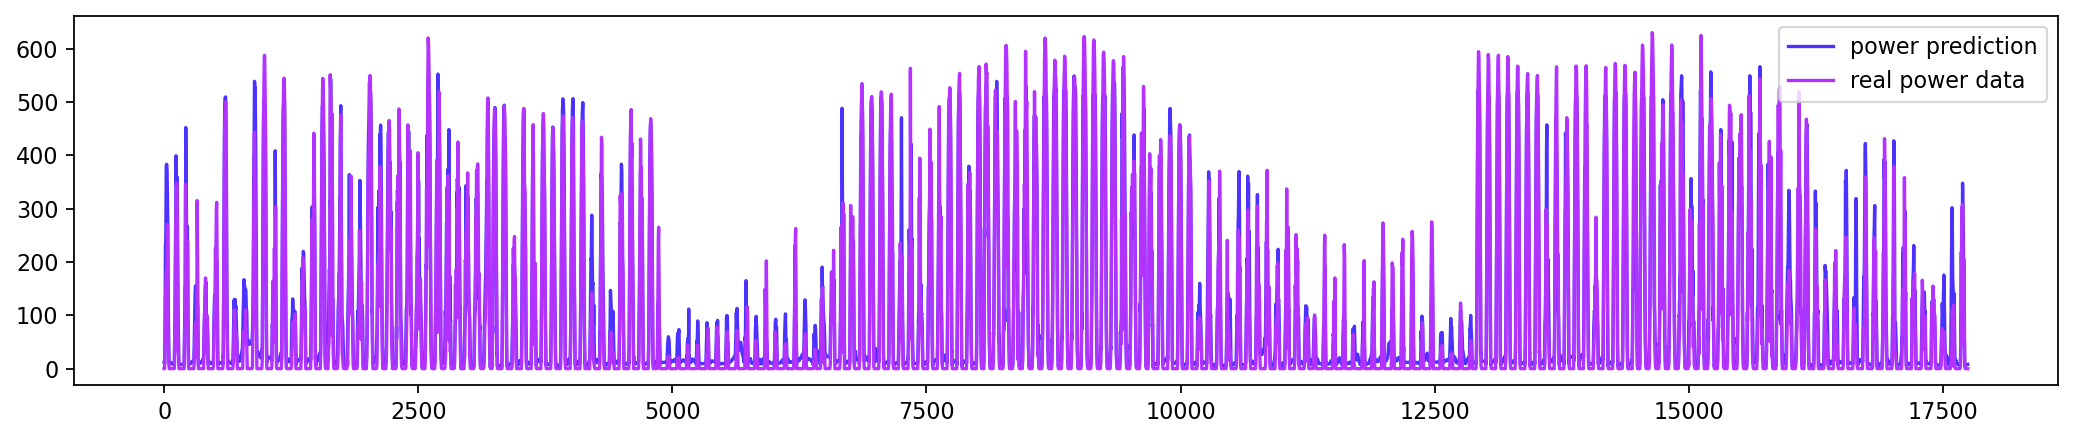

In [25]:
y_hat_val = model.predict(X_val)
y_hat_val = np.array([float(x) for x in y_hat_val])
y_hat_val = mm_scaler.inverse_transform(y_hat_val.reshape(-1, 1))
print('Validation MSE =', mean_squared_error(y_val, y_hat_val))

plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(y_hat_val))), y_hat_val, label='power prediction')
plt.plot(list(range(len(y_val))), y_val, label='real power data')
plt.legend()
plt.show()

Test MSE = 2262.4287879467015


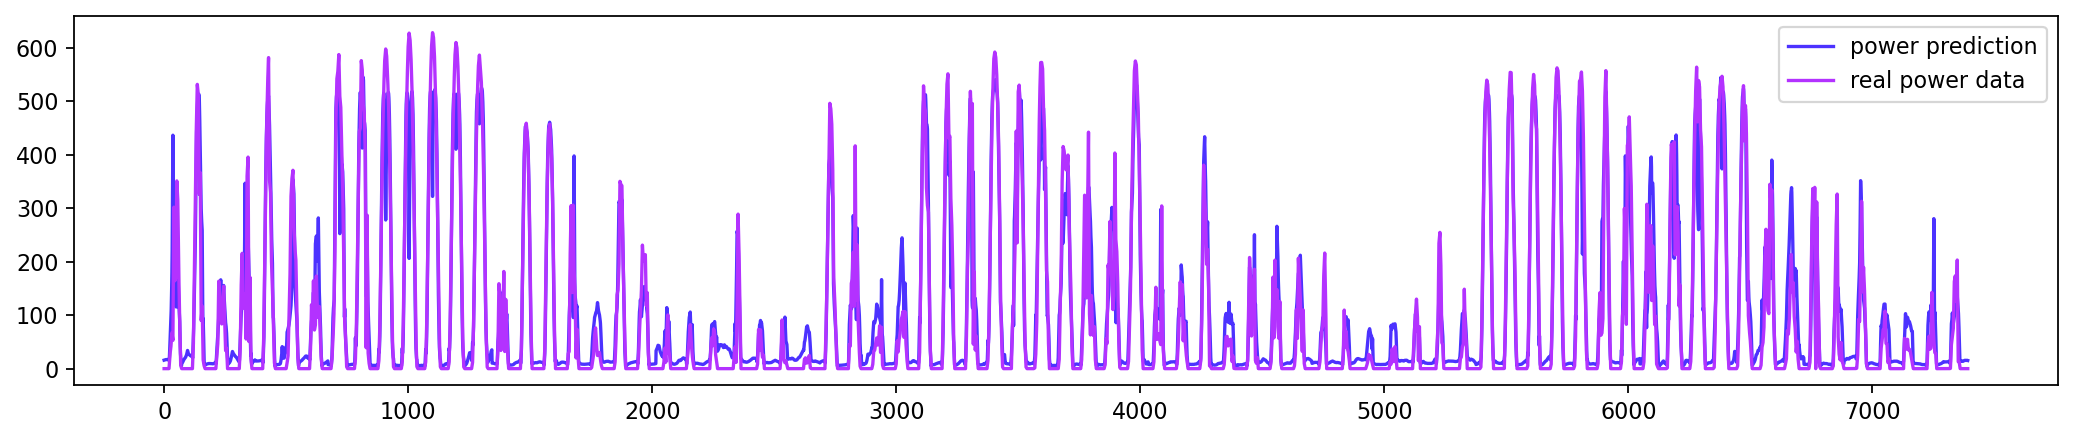

In [26]:
y_hat_test = model.predict(X_test)
y_hat_test = np.array([float(x) for x in y_hat_test])
y_hat_test = mm_scaler.inverse_transform(y_hat_test.reshape(-1, 1))
print('Test MSE =', mean_squared_error(y_test, y_hat_test))

plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(y_hat_test))), y_hat_test, label='power prediction')
plt.plot(list(range(len(y_test))), y_test, label='real power data')
plt.legend()
plt.show()

## <span style="color:#b332ff"> Computation of the residual load </span>

Now that we have estimated both the generated power and the energy load, we can substract the two to compute the residual load. We obtain the following performance :

| Set | MSE | RMSE |
| ---- | ---- | ---- |
| Train | 2830 | 53.20 |
| Validation | 2992 | 54.70 |
| Test | 2594 | 50.93 |

### <span style="color:#b332ff">Training set</span>

Train MSE = 2830.866813222514


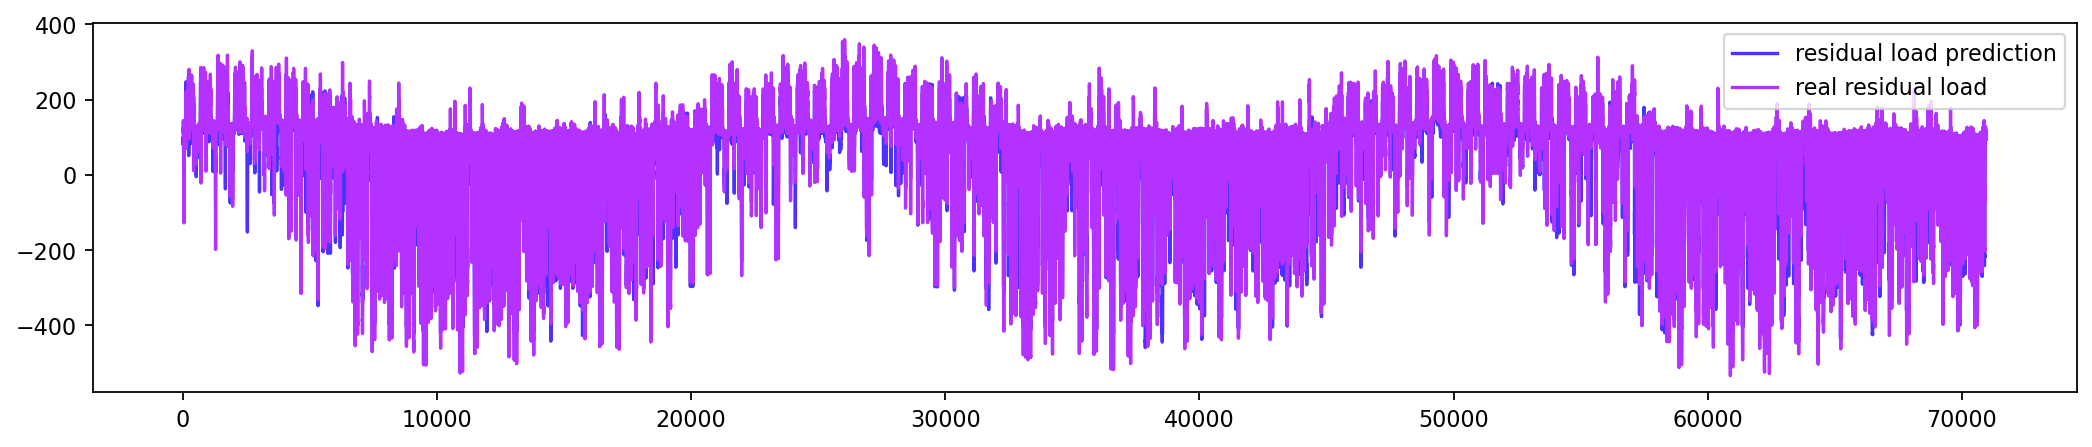

In [27]:
train_load_est = y_hat_train_load
train_power_est = y_hat_train
residual_est = train_load_est - train_power_est
residual_real = train_data['residual_load']

print('Train MSE =', mean_squared_error(residual_real, residual_est))
plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(residual_est))), residual_est, label='residual load prediction')
plt.plot(list(range(len(residual_real))), residual_real, label='real residual load')
plt.legend()
plt.show()

### <span style="color:#b332ff">Validation set</span>

Validation MSE = 2991.92792553363


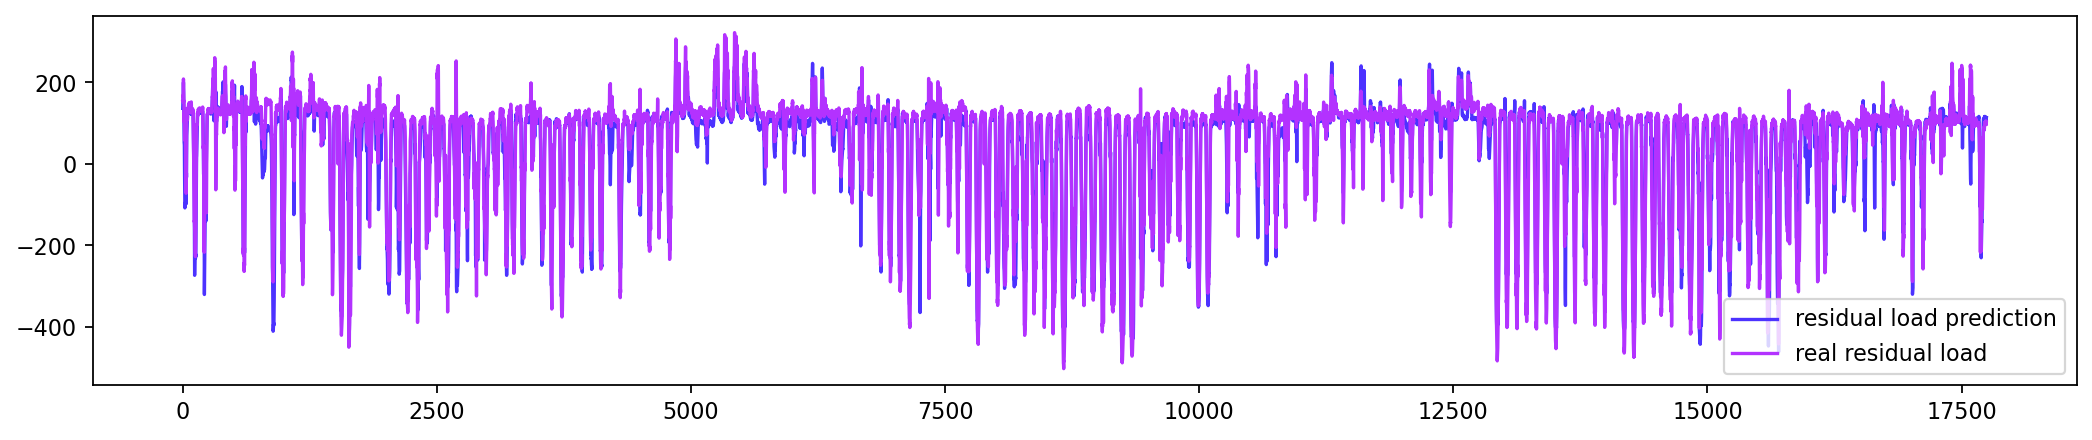

In [28]:
val_load_est = y_hat_val_load
val_power_est = y_hat_val
residual_est = val_load_est - val_power_est
residual_real = val_data['residual_load']

print('Validation MSE =', mean_squared_error(residual_real, residual_est))
plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(residual_est))), residual_est, label='residual load prediction')
plt.plot(list(range(len(residual_real))), residual_real, label='real residual load')
plt.legend()
plt.show()

### <span style="color:#b332ff">Test set</span>

Test MSE = 2594.036345418656


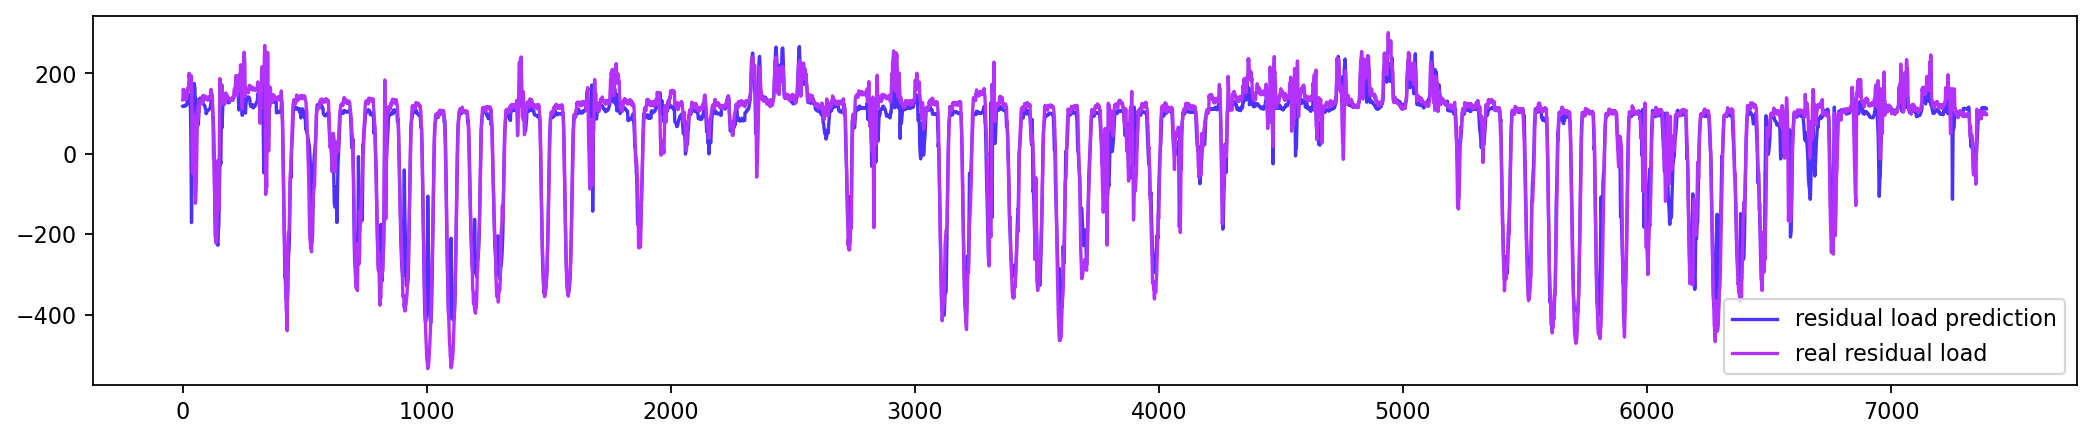

In [29]:
test_load_est = y_hat_test_load
test_power_est = y_hat_test
residual_est = test_load_est - test_power_est
residual_real = test_data['residual_load']

print('Test MSE =', mean_squared_error(residual_real, residual_est))
plt.figure(figsize=(16,3), dpi=80)
plt.plot(list(range(len(residual_est))), residual_est, label='residual load prediction')
plt.plot(list(range(len(residual_real))), residual_real, label='real residual load')
plt.legend()
plt.show()